## Create a RL Model that can select plants

In [1]:
import collections
import os
from typing import Union, List, Dict
import time

from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk, scan, streaming_bulk

# Map common python types to ES Types
TYPE_MAP = {
    "int": "integer",
    "float": "float",
    "double": "double",
    "str": "text",
    "bool": "boolean",
    "datetime": "date",
    "list[int]": "integer",
    "list[str]": "text",
    "list[float]": "float",
    "list[double]": "double",
    "torch.tensor": "dense_vector",
    "numpy.ndarray": "dense_vector",
    "keyword": "keyword"
}

MAX_BULK_SIZE = 100

os.environ['ELASTIC_USERNAME'] = 'elastic'
os.environ['ELASTIC_PASSWORD'] = '' #Do not push with this filled in
os.environ['ELASTIC_PORT'] = '9200'
os.environ['ELASTIC_HOST'] = 'localhost'

In [2]:
class ESManager():

    def __init__(self):
        self.url = f"http://{os.getenv('ELASTIC_HOST')}:{os.getenv('ELASTIC_PORT')}"
        self.username =  os.getenv('ELASTIC_USERNAME')
        self.password = os.getenv('ELASTIC_PASSWORD')

        self.client = Elasticsearch(self.url,
                                    verify_certs=False,
                                    basic_auth=(self.username, self.password), request_timeout=30, max_retries=10, retry_on_timeout=True)

        print(self.client.info())

        self.consolidated_actions = []

    def _check_data_type(self, var, var_type):
        try:
            assert type(var) == var_type
        except:
            return False
        return True

    def _check_valid_values(self, map_dict: dict) -> int:
        """
        Traverse mapping dictionary to ensure that all types are valid types within TYPE_MAP

        Args:
            map_dict (dict): Mapping to be checked

        Returns:
            int: 0 if there is invalid types, 1 otherwise

        """
        ret_val = 1
        for k, v in map_dict.items():
            if isinstance(v, dict):
                ret_val = self._check_valid_values(v)
            else:
                if not v in TYPE_MAP:
                    print(f"'{v}' type for '{k}' NOT FOUND")
                    return 0

        return ret_val * 1

    def _traverse_map(self, map_dict: Dict) -> Dict:
        """
        Traverse mapping dictionary to convert data type into framework specific type

        Args:
            map_dict (dict): Mapping to be used to create ES index

        Returns:
            dict: updated mapping dictionary

        """
        dictionary = {"properties": dict()}
        for k, v in map_dict.items():
            if isinstance(v, dict):
                dictionary['properties'][k] = self._traverse_map(v)
            else:
                dictionary['properties'][k] = {"type": TYPE_MAP[v]}
        return dictionary

    def _flush(self):
        errors = []
        list_of_es_ids = []
        for ok, item in streaming_bulk(self.client, self.consolidated_actions):
            if not ok:
                errors.append(item)
            else:
                list_of_es_ids.append(item['index']['_id'])
        if len(errors) != 0:
            print("List of faulty documents:", errors)
        self.consolidated_actions = []  # Reset List
        return list_of_es_ids

    def _flatten(self, d, parent_key='', sep='.'):
        """
        Flatten nested dictionary keys to dotted parameters because Elasticsearch. 
        """
        items = []
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.MutableMapping):
                items.extend(self._flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    def create_collection(self, collection_name: str, schema: Dict, custom_schema: bool = False) -> Dict:
        """
        Create the index on ElasticSearch

        Args:
            collection_name (str): Index name of ES
            schema (dict): Mapping to be used to create ES index
            custom_schema (bool): If set to True, user may input schema that in accordance to ElasticSearch Mapping's format. The schema will not be parsed. 

        Returns:
            dict: response of error, or 200 if no errors caught

        """
        if not self._check_data_type(schema, dict):
            return {"response": "Type of 'schema' is not dict"}
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(custom_schema, bool):
            return {"response": "Type of 'custom_schema' is not bool"}
        if custom_schema:
            try:
                self.client.indices.create(
                    index=collection_name, mappings=schema)
            except Exception as e:
                return {"response": f"{e}"}
            return {"response": "200"}
        else:
            mapping_validity = self._check_valid_values(schema)
            if not mapping_validity:
                return {"response": "KeyError: data type not found in TYPE_MAP"}
            updated_mapping = self._traverse_map(schema)
            try:
                self.client.indices.create(
                    index=collection_name, mappings=updated_mapping)
            except Exception as e:
                return {"response": f"{e}"}
            return {"response": "200"}

    def delete_collection(self, collection_name: str) -> dict:
        """
        Create the index on ElasticSearch

        Args:
            collection_name (str): Index name of ES
            schema (dict): Mapping to be used to create ES index

        Returns:
            dict: response of error, or 200 if no errors caught

        """
        try:
            self.client.indices.delete(index=collection_name)
        except Exception as e:
            return {"response": f"{e}"}
        return {"response": "200"}

    def create_document(self, collection_name: str, documents: Union[list, dict], id_field: str = None) -> dict:
        """
        Upload document(s) in the specified index within ElasticSearch

        Args:
            collection_name (str): Index name of ES
            documents (dict, list): A dict of document objects to be ingested. A list of dict is accepted as well. 
            id_field (str, Optional): Specify the key amongst the document object to be the id field. If not specified, id will be generated by ES. 

        Returns:
            dict: response of error along with the faulty document, or code 200 along with the ids of ingested document if no errors caught

        """
        if not self._check_data_type(documents, list):
            if not self._check_data_type(documents, dict):
                return {"response": "Type of 'documents' is not dict or a list"}
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not id_field is None:
            if not self._check_data_type(id_field, str):
                return {"response": "Type of 'id_field' is not str"}

        # If single document, wrap it in a list so it can be an iterable as it would be when a list of document is submitted
        if type(documents) == dict:
            documents = [documents]

        # If id_field is specified, verify that all documents possess the id_field.
        if id_field != None:
            for doc in documents:
                if not id_field in doc.keys():
                    print(
                        "Fix document, or set 'id_field' to None. No documents uploaded.")
                    return {"response": "Fix document, or set 'id_field' to None. No documents uploaded.",
                            "error_doc": doc}
                try:
                    doc[id_field] = str(doc[id_field])
                except Exception as e:
                    return {"response": "id cannot be casted to String type. No documents uploaded.",
                            "error_doc": doc}
        all_id = []
        for doc in documents:
            doc_copy = dict(doc)
            action_dict = {}
            action_dict['_op_type'] = 'index'
            action_dict['_index'] = collection_name
            if id_field != None:
                action_dict['_id'] = doc_copy[id_field]
                doc_copy.pop(id_field)
            action_dict['_source'] = doc_copy
            self.consolidated_actions.append(action_dict)
            if len(self.consolidated_actions) == MAX_BULK_SIZE:
                all_id = all_id+self._flush()

        all_id = all_id+self._flush()

        return {"response": "200", "ids": all_id}

    def delete_document(self, collection_name: str, doc_id: str) -> dict:
        """
        Delete document from index based on the specified document id. 

        Args:
            collection_name (str): Index name of ES
            doc_id (str): id of doc to be deleted

        Returns:
            dict: response of error along with the faulty document, or code 200 along with elastic API response

        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(doc_id, str):
            return {"response": "Type of 'doc_id' is not str"}

        # Check for document's existence
        search_result = self.client.search(index=collection_name, query={
                                           "match": {"_id": doc_id}})
        result_count = search_result['hits']['total']['value']

        if result_count == 0:
            return {"response": f"Document '{doc_id}' not found!"}

        try:
            resp = self.client.delete(index=collection_name, id=doc_id)
        except Exception as e:
            return {"response": f"{e.__class__.__name__}. Document Deletion failed"}

        return {"response": "200", "api_resp": resp}

    def update_document(self, collection_name: str, doc_id: str, document: dict) -> dict:
        """
        Delete document from index based on the specified document id. 

        Args:
            collection_name (str): Index name of ES
            doc_id (str): id of doc to be updated
            document (dict): key and values of fields to be updated.

        Returns:
            dict: response of error along with the faulty document, or code 200 along with elastic API response

        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(doc_id, str):
            return {"response": "Type of 'doc_id' is not str"}
        if not self._check_data_type(document, dict):
            return {"response": "Type of 'document' is not dict"}

        # Check for document's existence
        search_result = self.client.search(index=collection_name, query={
                                           "match": {"_id": doc_id}})
        result_count = search_result['hits']['total']['value']

        if result_count == 0:
            return {"response": f"Document '{doc_id}' not found, create document first"}

        try:
            for key in document.keys():

                q = {
                    "script": {
                        "source": f"ctx._source.{key}=params.infer",
                        "params": {
                            "infer": document[key]
                        },
                        "lang": "painless"
                    },
                    "query": {
                        "match": {
                            "_id": doc_id
                        }
                    }
                }
                resp = self.client.update_by_query(
                    body=q, index=collection_name)
        except Exception as e:
            return {"response": f"{e.__class__.__name__}. Document Update failed"}

        return {"response": "200", "api_resp": resp}

    def read_document(self, collection_name: str, doc_id: str) -> dict:
        """
        Read document from index based on the specified document id. 

        Args:
            collection_name (str): Index name of ES
            doc_id (str): id of doc to be read

        Returns:
            dict: response of error along with the faulty document, or code 200 along with the retrieved document

        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(doc_id, str):
            return {"response": "Type of 'doc_id' is not str"}

        # Check for document's existence
        search_result = self.client.search(index=collection_name, query={
                                           "match": {"_id": doc_id}})
        result_count = search_result['hits']['total']['value']

        if result_count == 0:
            return {"response": f"Document '{doc_id}' not found!"}

        doc_body = search_result['hits']['hits']

        return {"response": "200", "api_resp": doc_body}

    def query_collection(self, collection_name: str, field_value_dict: dict) -> dict:
        """
        Read document from index based on the specific key-value dictionary query. 

        Args:
            collection_name (str): Index name of ES
            field_value_dict (dict): A dictionary with the field to be queried as the key, and the value to be queried as the value of the dictionary. 
                                    example: {"field1":"query1", "field2", "query2"}

        Returns:
            dict: response of error along with the faulty document, or code 200 along with the list of retrieved document

        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(field_value_dict, dict):
            return {"response": "Type of 'field_value_dict' is not dict"}

        # Check for document's existence
        reorg_dict = {"bool":{
            "should":[]
            }
        }
        for field in field_value_dict:
            reorg_dict['bool']['should'].append({"match":{field:field_value_dict[field]}})

        search_result = self.client.search(index=collection_name, query=reorg_dict)
        result_count = search_result['hits']['total']['value']

        if result_count == 0:
            return {"response": f"No documents found."}

        docs = search_result['hits']['hits']

        return {"response": "200", "api_resp": docs}

    def custom_query(self, collection_name: str, query: dict) -> dict:
        """
        Read document from index based on custom ES query syntax. 

        Args:
            collection_name (str): Index name of ES
            query (dict): Custom query for ES users who are familiar with the query format

        Returns:
            dict: response of error along with the faulty document, or code 200 along with the list of retrieved document

        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        if not self._check_data_type(query, dict):
            return {"response": "Type of 'field_value_dict' is not dict"}

        # Check for document's existence
        search_result = self.client.search(index=collection_name, query=query)
        result_count = search_result['hits']['total']['value']

        if result_count == 0:
            return {"response": f"No documents found."}

        docs = search_result['hits']['hits']

        return {"response": "200", "api_resp": docs}

    def get_all_documents(self, collection_name: str) -> dict:
        """
        Generator method to retrieve all documents within the index

        Args:
            collection_name (str): Index name of ES

        Returns:
            Generator Object: Iterable object containing all documents within index specified. 
        """
        if not self._check_data_type(collection_name, str):
            return {"response": "Type of 'collection_name' is not str"}
        docs_response = scan(self.client, index=collection_name, query={
                             "query": {"match_all": {}}})
        for item in docs_response:
            yield item

In [4]:
esManager = ESManager()

{'name': 'cb6c3cd618a0', 'cluster_name': 'docker-cluster', 'cluster_uuid': '-_Y1cDZUQIqwvt6jJyQ_fA', 'version': {'number': '8.10.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'a94744f97522b2b7ee8b5dc13be7ee11082b8d6b', 'build_date': '2023-09-14T20:16:27.027355296Z', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [5]:
result = esManager.query_collection('flora', {
    "Plant Type.keyword": "Tree",
    "Water Preference.keyword": "Moderate",
    "Trunk Colour.keyword": "red",
    "Attracted animals.keyword": "butterfly"
})

print(len(result['api_resp']))
for data in result['api_resp']:
    print(data['_source'])
    print(data['_score'])

10
{'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', 'Leaf Texture': ['N/A']}
3.8889275
{'Scientific Name': 'Sonneratia caseolaris (L.) Engl.', 'Common Name': 'Crabap

In [6]:
query = {
    "bool": {
        "must": [
            {"term": {"Plant Type.keyword": "Tree"}},
            {"term": {"Water Preference.keyword": "Moderate Water"}},
        ],
        "should": [
            {"match": {"Trunk Colour": {"query": "red"}}}
        ]
    }
}

result = esManager.custom_query('flora', query)
print(result)
print(len(result['api_resp']))
for data in result['api_resp']:
    print(data['_source'])
    print(data['_score'])

{'response': '200', 'api_resp': [{'_index': 'flora', '_id': 'Ucz7y5IBzYt0LoDihG73', '_score': 4.886512, '_source': {'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', '

## NVM we try and figure out the RL for planting the plants first then get the database

In [7]:
exampleData = {'response': '200', 'api_resp': [{'_index': 'flora', '_id': 'Ucz7y5IBzYt0LoDihG73', '_score': 4.886512, '_source': {'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'U8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Parkia speciosa Hassk.', 'Common Name': 'Petai', 'Species ID': 3052, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/0/3052', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 45.0, 'Flower Colour': 'Cream / Off-White, White, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting, Butterfly Host Plant, Bat Food', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest, Riverine)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'smooth', 'Trunk Colour': 'reddish-brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'WMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cassia grandis L. f.', 'Common Name': 'Horse Cassia', 'Species ID': 2788, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/7/2788', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 25.0, 'Flower Colour': 'Orange, Pink, Red', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Riverine)', 'Mature Leaf Colour': 'Green, Purple', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Smooth', 'Trunk Colour': 'Light grey', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Wcz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cratoxylum cochinchinense (Lour.) Blume', 'Common Name': 'Derum Selunchor', 'Species ID': 2829, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2829', 'Plant Type': ['Shrub', 'Tree'], 'Light Preference': ['Full Sun', 'Semi Shade'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Red, Orange, Pink', 'Hazard': 'N/A', 'Attracted animals': 'Butterfly Host Plant (Leaves, Associated with: Eurema  hecabe contubernalis (Moore, 1886), Lexias pardalis), Bee-Attracting', 'Native habitat': 'Terrestrial (Secondary Rainforest, Primary Rainforest, Freshwater Swamp Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Peeling / Flaking / Papery, Smooth', 'Trunk Colour': 'Reddish-brown', 'Leaf Texture': ['Medium']}}, {'_index': 'flora', '_id': 'W8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Corymbia ptychocarpa (F. Muell.) K. D. Hill & L. A. S. Johnson', 'Common Name': 'Spring Bloodwood', 'Species ID': 2887, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2887', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 20.0, 'Flower Colour': 'Pink, Red', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting', 'Native habitat': 'Terrestrial (Secondary Rainforest, Riverine)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured', 'Trunk Colour': 'Reddish-brown to greyish-brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'XMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cola gigantea A.Chev.', 'Common Name': 'Giant Cola', 'Species ID': 2821, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2821', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 35.0, 'Flower Colour': 'Purple', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'brown', 'Trunk Colour': 'brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Xcz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Erythrina fusca Lour.', 'Common Name': 'Coral Tree', 'Species ID': 2879, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2879', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 15.0, 'Flower Colour': 'Orange, Red', 'Hazard': 'Spines/Thorns - Stem/Branch, Spines/Thorns - Trunk, Toxic Upon Ingestion', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Coastal Forest, Riverine), Shoreline (Sandy Beach)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Peeling / Flaking / Papery', 'Trunk Colour': 'Brownish grey, brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'X8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Samanea saman (Jacq.) Merr.', 'Common Name': 'Rain Tree', 'Species ID': 3106, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/1/3106', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Pink, White', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Primary Rainforest, Grassland / Savannah/ Scrubland)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured', 'Trunk Colour': 'Dark brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'ZMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Xanthostemon chrysanthus (F.Muell.) Benth.', 'Common Name': 'Golden Penda', 'Species ID': 3200, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/2/3200', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 40.0, 'Flower Colour': 'Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting, Butterfly-Attracting, Bee-Attracting', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Scaly, Smooth', 'Trunk Colour': 'Brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Zsz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Sterculia macrophylla Vent.', 'Common Name': 'Broad-leaved Sterculia', 'Species ID': 3138, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/1/3138', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 40.0, 'Flower Colour': 'Yellow / Golden, Pink', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest, Freshwater Swamp Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'smooth', 'Trunk Colour': 'light grey', 'Leaf Texture': ['N/A']}}]}

In [8]:
print(exampleData)

{'response': '200', 'api_resp': [{'_index': 'flora', '_id': 'Ucz7y5IBzYt0LoDihG73', '_score': 4.886512, '_source': {'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', '

Categories to consider:
_index: ??? serach term for elastic search?

_id: tracking ID

-score: ??? 

_source
- Scientific Name
- Common Name
- Species ID
- Link
- <s><b>Water Preference </b>: Environment consideration </s> (Should be given)
- <s><b>Drough Tolerant </b>: Environment consideration  </s>(Should be given)
- Native to SG
- <s><b>Fruit Bearing </b>: Theme Consideration</s> (Assume T/F)
- <s><b>Fragrant Plant </b>: Theme Consideration </s> (Assume T/F)
- <s><b>Attracted animals </b>: Theme Consideration </s> (Assume T/F)
- Native habitats
- <s><b>Growth Rate </b>: Special Consideration? (Plants should be similar in this field imo) </s> (Assume all consistent)

- <b>Plant Type </b>: Model Determinant
- <b>Light Preference </b>: Environment consideration
- <b>Hazard </b>
- <b>Flower Color </b>: Theme Consideration
- <b>Maximum height </b>
- <b>Trunk Texture </b>: Theme Consideration
- <b>Trunk Color </b>: Theme Consideration
- <b>Leaf Texture </b>: Theme Consideration
- <b>Leaf Color </b>

## Things the RL model should consider,

Input from previous model: Take in a grid wit certain squares that have been labelled for shrub planting and several spots that have been labelled for tree planting and a grid:

- Tree Spots
- Shrub Spots
- Grid

Things Decided by what model:
- Plant type: Search the database and select plant types that match the current plant type being selected

Things that have to be somehow simulated/decided by an environment
- Light Preference
- Water Preference
- Drought Tolerant

Things that the theme will provide:
- Fruit Bearing: true/false based on the area type
- Fragrant Plant: true/false based on the area type
- Attracted animals: I presume that we will need to find based on <b> Bird </b>, <b> Butterfly </b>, <b> Bat(????) </b>

Things that should be used to match plants together:
- Growth Rate

How in the artsy fartsy:
- Flower color:
- Trunk Color
- Trunk Texture


Two models, one for tree, one for shrubs.
- Tree model would have to place 1/(2 possibly) types of tree
- Shrub model would segment the shrubs into distinct catregories before selecting types of shrubs accordingly
    - Naturalistic would use clusters probably
    - Manequred would detect straight lines or contours to classify boundary/rows of shrubs before populating the rest with another kind, I think that's how it works

Decide between two approaches
- Approach 1, deciding trees first, selecting shrubs based on the tree
- Approach 2, placing the shrubs to maximise score before deciding tree, based on the parcel/ship organisation paper

I think I will go with approach 1, just cause I have no clear succes factor or mesurement index to count score for.

## Things experiented with

Two stage model
- RL model that takes in output from first model to be used as an argument in the observation space.


Action space,
- Kinda want to make it decide on ideal factors, ie light/water and useing that we can have a reason to randomly regenerate without having to worry about the output being the same, it would also allow the model to scale with size
- ie model to decide best fit criteria for a plant before getting plants that meet that criteria


- Assuming given a certain number of plants, some distribution 

- <b>Plant Type </b>: Model Determinant
- <b>Light Preference </b>: Environment consideration, always given shade loving, if there is sun loving, sun loving should not be a certain radius within tree
- <b>Hazard </b>: if plant has hazard, should not be within certain distance from exterior
- <b>Flower Color </b>: Theme Consideration
- <b>Maximum height </b>: Shrub to fit underneath tree first, in future someone can add a height scale
- <b>Trunk Texture </b>: Theme Consideration
- <b>Trunk Color </b>: Theme Consideration
- <b>Leaf Texture </b>: Theme Consideration
- <b>Leaf Color </b>

## Task 1, plant a tree

Given 3 trees, with a certain set of embedding to represent what they are

- The RL model will try to place the trees,
- if naturalistic, will be reward more for variety
- if maniqured, will be penalized for less variety

Until the shrub model is complete, will be substituted will rng gen

Task 2, classification of shurbs into common groups

- Radius near each tree, true or false based on whether within radius of a tree
- Close to border, true or false based on minimum distance from the border


## Task 3, Selecting of plants for shrub based on the assigned group
Take different group then choose plant accoreding to environment variables averaged among included points

- Decides flower color
- Decideds leaf color
- Decides leaf texture
- hazard level

based on trunk texture

Loaded model from ./models/23rd.zip
Episode finished after 433 steps
Trees placed at: [(76, 8), (84, 80), (92, 88)]
Shrubs placed at: [(8, 60), (8, 84), (18, 62), (18, 74), (26, 68), (26, 94), (32, 58), (32, 76), (34, 86), (40, 52), (40, 94), (42, 76), (46, 86), (48, 60), (50, 70), (52, 94), (54, 80), (60, 64), (60, 88), (62, 74), (68, 82), (68, 94), (72, 72), (76, 88), (84, 94), (86, 6)]


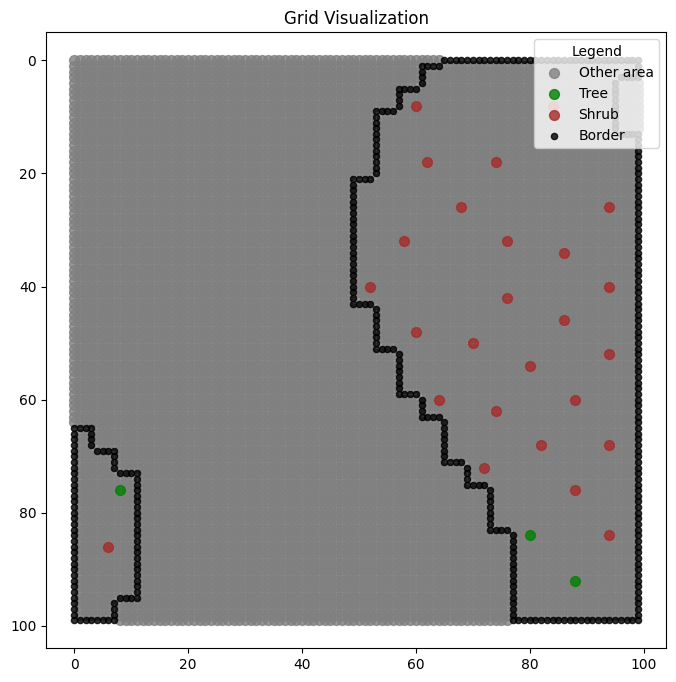

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import os

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
        self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

        # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
            "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
            "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
            "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
            "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def main(model_path):
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()


if __name__ == "__main__":
    # Specify the path to the pretrained model directory
    model_path = "./models/23rd.zip"
    final_grid = main(model_path)
    trees, shrubs = extract_tree_shrub_placements(final_grid)
    print("Trees placed at:", trees)
    print("Shrubs placed at:", shrubs)

    # Optional visualization
    visualize_grid_with_circles(final_grid)


Loaded model from ./models/23rd.zip
Episode finished after 479 steps


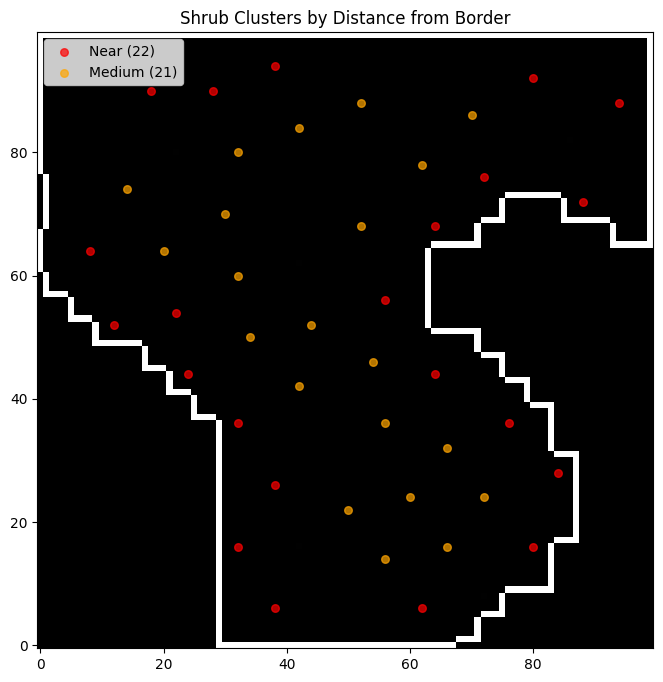

In [22]:
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each shrub to the nearest white border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    # Create a binary mask where the border pixels are 1
    border_mask = (grid == border_value).astype(int)
    
    # Calculate the Euclidean distance transform for each pixel
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def categorize_shrubs_by_distance(grid, distance_map, shrub_value=2, near_thresh=10, far_thresh=30):
    """
    Categorize shrubs based on their radial distance to the border.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        distance_map (np.ndarray): The distance of each point to the nearest border.
        shrub_value (int): Value in the grid representing shrubs.
        near_thresh (float): Threshold distance for "Near" category.
        far_thresh (float): Threshold distance for "Far" category.

    Returns:
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    clusters = {"Near": [], "Medium": [], "Far": []}

    # Categorize each shrub based on distance
    for coord in shrub_coords:
        distance = distance_map[coord[0], coord[1]]
        if distance <= near_thresh:
            clusters["Near"].append(tuple(coord))
        elif distance <= far_thresh:
            clusters["Medium"].append(tuple(coord))
        else:
            clusters["Far"].append(tuple(coord))

    return clusters

def plot_shrub_clusters(grid, clusters):
    """
    Visualize shrub clusters on the grid.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap="gray", origin="upper")

    # Define colors for each category
    colors = {"Near": "red", "Medium": "orange", "Far": "green"}

    # Plot each category with a unique color
    for category, color in colors.items():
        if clusters[category]:  # Only plot if there are coordinates in the category
            y_coords, x_coords = zip(*clusters[category])
            plt.scatter(x_coords, y_coords, color=color, label=f"{category} ({len(clusters[category])})", s=30, alpha=0.7)

    plt.legend()
    plt.title("Shrub Clusters by Distance from Border")
    plt.gca().invert_yaxis()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border
    distance_map = calculate_distance_to_border(final_grid)

    # Categorize shrubs by their distance to the border
    clusters = categorize_shrubs_by_distance(final_grid, distance_map)

    # Plot the categorized clusters
    plot_shrub_clusters(final_grid, clusters)


Loaded model from ./models/23rd.zip
Episode finished after 678 steps


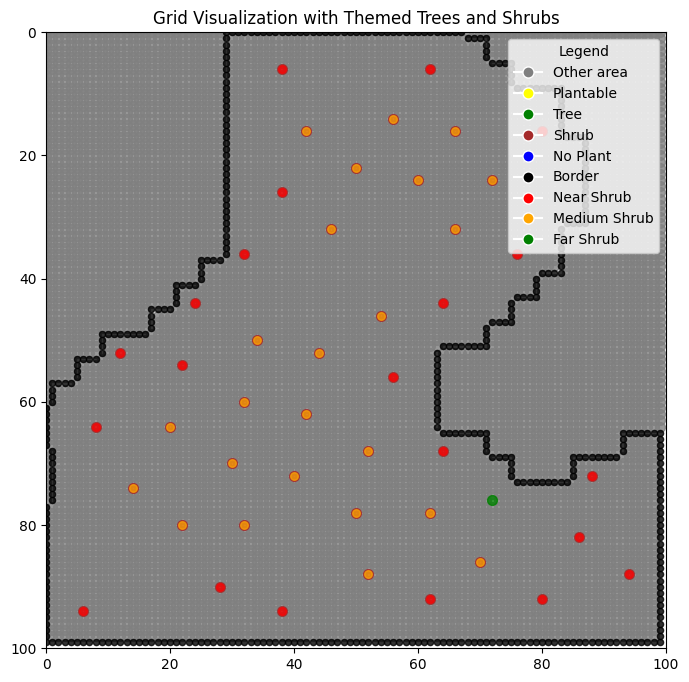

In [25]:
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each shrub to the nearest white border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    # Create a binary mask where the border pixels are 1
    border_mask = (grid == border_value).astype(int)
    
    # Calculate the Euclidean distance transform for each pixel
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def categorize_shrubs_by_distance(grid, distance_map, shrub_value=2, near_thresh=10, far_thresh=30):
    """
    Categorize shrubs based on their radial distance to the border.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        distance_map (np.ndarray): The distance of each point to the nearest border.
        shrub_value (int): Value in the grid representing shrubs.
        near_thresh (float): Threshold distance for "Near" category.
        far_thresh (float): Threshold distance for "Far" category.

    Returns:
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    clusters = {"Near": [], "Medium": [], "Far": []}

    # Categorize each shrub based on distance
    for coord in shrub_coords:
        distance = distance_map[coord[0], coord[1]]
        if distance <= near_thresh:
            clusters["Near"].append(tuple(coord))
        elif distance <= far_thresh:
            clusters["Medium"].append(tuple(coord))
        else:
            clusters["Far"].append(tuple(coord))

    return clusters

def visualize_grid_with_circles(grid, clusters=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        clusters (dict): Optional dictionary with shrub coordinates categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles based on your preferences
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Default Shrub color
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},  # No Plant selected
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # If clusters are provided, override shrub colors based on distance categories
    if clusters:
        cluster_colors = {"Near": "red", "Medium": "orange", "Far": "green"}
        for category, color in cluster_colors.items():
            if clusters[category]:  # Only plot if there are coordinates in the category
                y_coords, x_coords = zip(*clusters[category])
                plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub ({len(clusters[category])})", s=30, alpha=0.7)

    # Customize the plot further
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, color in cluster_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"{category} Shrub"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border
    distance_map = calculate_distance_to_border(final_grid)

    # Categorize shrubs by their distance to the border
    clusters = categorize_shrubs_by_distance(final_grid, distance_map)

    # Plot the categorized clusters with theming
    visualize_grid_with_circles(final_grid, clusters)


## Including distance from trees as well

Loaded model from ./models/23rd.zip
Episode finished after 1060 steps


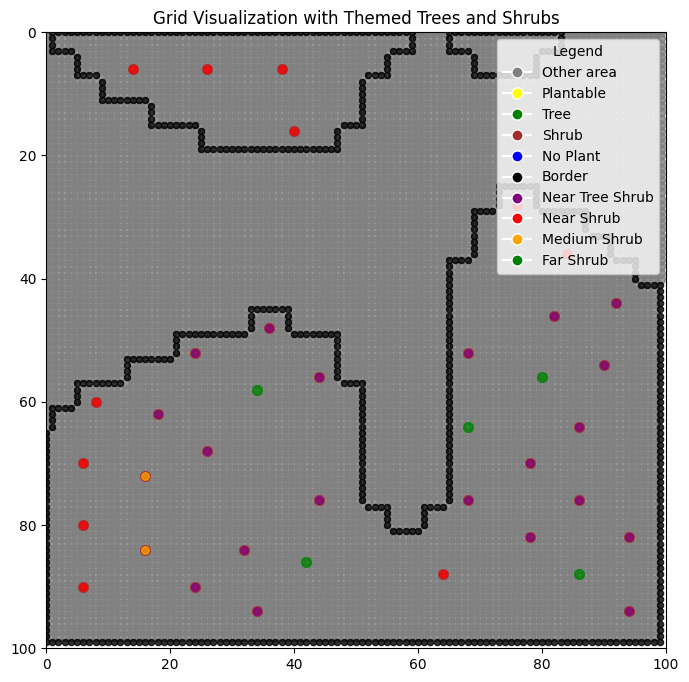

In [5]:
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each plot to the nearest border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    border_mask = (grid == border_value).astype(int)
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def calculate_distance_to_tree(grid, tree_value=1):
    """
    Calculate the Euclidean distance from each plot to the nearest tree.

    Args:
        grid (np.ndarray): The grid with shrub placements and trees.
        tree_value (int): Value in the grid representing trees.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest tree.
    """
    tree_mask = (grid == tree_value).astype(int)
    distance_map = distance_transform_edt(1 - tree_mask)  # Invert mask so distance is from tree pixels
    return distance_map

def categorize_shrubs_by_distance(grid, border_distance_map, tree_distance_map, shrub_value=2, near_tree_thresh=20, near_thresh=10, far_thresh=50):
    """
    Categorize shrubs based on their distance to the nearest border or tree.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        border_distance_map (np.ndarray): The distance of each point to the nearest border.
        tree_distance_map (np.ndarray): The distance of each point to the nearest tree.
        shrub_value (int): Value in the grid representing shrubs.
        near_tree_thresh (float): Threshold distance for "Near Tree" category.
        near_thresh (float): Threshold distance for "Near" category.
        far_thresh (float): Threshold distance for "Far" category.

    Returns:
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    clusters = {"Near Tree": [], "Near": [], "Medium": [], "Far": []}

    # Categorize each shrub based on distances
    for coord in shrub_coords:
        tree_distance = tree_distance_map[coord[0], coord[1]]
        border_distance = border_distance_map[coord[0], coord[1]]
        
        if tree_distance <= near_tree_thresh:
            clusters["Near Tree"].append(tuple(coord))
        elif border_distance <= near_thresh:
            clusters["Near"].append(tuple(coord))
        elif border_distance <= far_thresh:
            clusters["Medium"].append(tuple(coord))
        else:
            clusters["Far"].append(tuple(coord))

    return clusters

def visualize_grid_with_circles(grid, clusters=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        clusters (dict): Optional dictionary with shrub coordinates categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles based on your preferences
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Default Shrub color
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},  # No Plant selected
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # If clusters are provided, override shrub colors based on distance categories
    if clusters:
        cluster_colors = {"Near Tree": "purple", "Near": "red", "Medium": "orange", "Far": "green"}
        for category, color in cluster_colors.items():
            if clusters[category]:  # Only plot if there are coordinates in the category
                y_coords, x_coords = zip(*clusters[category])
                plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub ({len(clusters[category])})", s=30, alpha=0.7)

    # Customize the plot further
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, color in cluster_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"{category} Shrub"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border
    border_distance_map = calculate_distance_to_border(final_grid)

    # Calculate distance to the nearest tree
    tree_distance_map = calculate_distance_to_tree(final_grid)

    # Categorize shrubs by their distance to the border and tree proximity
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)

    # Plot the categorized clusters with theming
    visualize_grid_with_circles(final_grid, clusters)


Convert this to a dictionary of values for each point, such as {near_tree: 1, near_border: 1, med_boarder: 0} and use that to classify each area

In [2]:
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each plot to the nearest border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    border_mask = (grid == border_value).astype(int)
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def calculate_distance_to_tree(grid, tree_value=1):
    """
    Calculate the Euclidean distance from each plot to the nearest tree.

    Args:
        grid (np.ndarray): The grid with shrub placements and trees.
        tree_value (int): Value in the grid representing trees.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest tree.
    """
    tree_mask = (grid == tree_value).astype(int)
    distance_map = distance_transform_edt(1 - tree_mask)  # Invert mask so distance is from tree pixels
    return distance_map

def classify_shrubs(grid, border_distance_map, tree_distance_map, shrub_value=2, near_tree_thresh=20, near_thresh=10, far_thresh=50):
    """
    Classify each shrub based on its distance to the nearest border and tree.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        border_distance_map (np.ndarray): The distance of each point to the nearest border.
        tree_distance_map (np.ndarray): The distance of each point to the nearest tree.
        shrub_value (int): Value in the grid representing shrubs.
        near_tree_thresh (float): Threshold distance for "Near Tree" category.
        near_thresh (float): Threshold distance for "Near Border" category.
        far_thresh (float): Threshold distance for "Medium Border" category.

    Returns:
        shrub_classifications (dict): Dictionary with shrub coordinates and their classification.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    shrub_classifications = {}

    # Classify each shrub based on distances
    for coord in shrub_coords:
        tree_distance = tree_distance_map[coord[0], coord[1]]
        border_distance = border_distance_map[coord[0], coord[1]]
        
        # Define classification dictionary for each shrub
        classification = {
            "near_tree": 1 if tree_distance <= near_tree_thresh else 0,
            "near_border": 1 if border_distance <= near_thresh else 0,
            "med_border": 1 if near_thresh < border_distance <= far_thresh else 0,
            "far_border": 1 if border_distance > far_thresh else 0
        }
        
        # Add the shrub classification to the dictionary
        shrub_classifications[tuple(coord)] = classification

    return shrub_classifications

def visualize_grid_with_circles(grid, shrub_classifications=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        shrub_classifications (dict): Dictionary with shrub coordinates and their classification.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles based on your preferences
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Default Shrub color
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},  # No Plant selected
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # If shrub classifications are provided, plot each category of shrubs with different colors
    if shrub_classifications:
        colors = {"near_tree": "purple", "near_border": "red", "med_border": "orange", "far_border": "green"}
        for coord, classification in shrub_classifications.items():
            for category, is_near in classification.items():
                if is_near == 1:
                    plt.scatter(coord[1], coord[0], color=colors[category], label=f"{category} Shrub", s=30, alpha=0.7)

    # Customize the plot further
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, color in colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"{category} Shrub"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border
    border_distance_map = calculate_distance_to_border(final_grid)

    # Calculate distance to the nearest tree
    tree_distance_map = calculate_distance_to_tree(final_grid)

    # Classify shrubs by their proximity to border and trees
    shrub_classifications = classify_shrubs(final_grid, border_distance_map, tree_distance_map)

    # Print shrub classifications (useful for feeding into RL observation space)
    for coord, classification in shrub_classifications.items():
        print(f"Shrub at {coord}: {classification}")

    # Plot the grid with shrub classifications
    visualize_grid_with_circles(final_grid, shrub_classifications)


NameError: name 'main' is not defined

### Experiment with a two stage RL model

In [11]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import random

class CustomEnvWithModelAOutput(gym.Env):
    def __init__(self):
        super(CustomEnvWithModelAOutput, self).__init__()
        
        # Define the main observation space, including the original state and the output from "Model A"
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(4)
        
        # Initialize state and model A output placeholder
        self.state = None
        self.model_a_output = None

    def reset(self, seed=None, options=None):
        # Handle seeding
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
            random.seed(seed)
        
        # Reset the state and model A output
        self.state = np.random.rand(5).astype(np.float32)
        self.model_a_output = self.calculate_model_a_output(self.state)
        
        # Combine the state and the "Model A" output into a single observation
        combined_state = np.concatenate([self.state, self.model_a_output]).astype(np.float32)
        return combined_state, {}

    def step(self, action):
        # Example reward based on the action (customize based on your task)
        reward = -np.sum(np.square(self.state - action))

        # Update state and recalculate "Model A" output
        self.state = np.random.rand(5).astype(np.float32)
        self.model_a_output = self.calculate_model_a_output(self.state)

        # Combine the state and the "Model A" output into a single observation
        combined_state = np.concatenate([self.state, self.model_a_output]).astype(np.float32)
        
        # Define episode termination conditions
        done = np.random.rand() > 0.95  # Random termination condition for example
        truncated = False  # We won’t use truncated in this example
        
        return combined_state, reward, done, truncated, {}

    def calculate_model_a_output(self, state):
        # Define the logic for "Model A" output based on the state.
        # This could be a more complex function that simulates the output of Model A
        # For simplicity, we just add some transformation here as an example.
        return (state * 0.5 + 0.25).astype(np.float32)  # Simple transformation as placeholder

# Train the PPO model with this environment
env = DummyVecEnv([lambda: CustomEnvWithModelAOutput()])
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1000)


## Let's attempt to create a RL model using presupposed groupings